In [2]:
##################################################################################
#                        Anti-Correlation Region Analysis                        #
#  A code to analyze SAM correlation plots produced in Matlab using an OpenCV AI #
#      to identify anti-correlation regions, and find their centers & areas      #
#                              Author: Steven Doran                              #
##################################################################################

# import OpenCV packages
import cv2 as cv
import numpy as np

path1 = '../Matlab Analysis/Correlation_Images/Negative_Plots/t100_150/ASIC_'
path2 = '_neg[0][100]_t100_150.png'

# Specify Number of ASICs
N = 6

ACR = []   # Anti-correlation region array
for i in range(0,3):
    ACR.append([])
for i in range(len(ACR)):
    for j in range(N):
        ACR[i].append([])
        
# ACR[0] = x coordinate of center position
# ACR[1] = y coordinare of center position
# ACR[2] = area of contour

def ACR_finder(ChipIndex):

    # Crop image so that we are only focused on the central plot region
    img = cv.imread(path1 + str(ChipIndex+1) + path2)   # adjust this "+1" in the string if you start at ASIC 0 (or 10 etc...)
    # img['top':'bottom', 'left:right'] -- x and y flipped (y, x)
    
    # This needs to be optimized for different ASICs. Crop the image as to only include the 'plot' region of the .png files.
    # This will vary WILDLY from computer to computer. Produce an example image to see where exactly you need to crop the
    # .png file as to only include the internal plot region (i.e., crop just inside of the external lines of the figure).
    crop_img = img[118:1391, 203:1365]
    cv.imwrite("junk.png",crop_img)

    image = cv.imread("junk.png")
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # Noise reduction, negative color filtering, and image thresholding
    blur = cv.GaussianBlur(gray, (5, 5),
                           cv.BORDER_DEFAULT)
    ret, thresh = cv.threshold(blur, 200, 255,
                               cv.THRESH_BINARY_INV)

    # create negative
    cv.imwrite("thresh_junk.png", thresh)

    # Contour finding
    contours, hierarchies = cv.findContours(
        thresh, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

    blank = np.zeros(thresh.shape[:2],
                     dtype='uint8')

    # draw the contours and produce image
    cv.drawContours(blank, contours, -1,
                    (255, 0, 0), 1)

    cv.imwrite("Contours_junk.png", blank)
    
    # Dimensionalize the array
    for i in range(len(contours)):
        ACR[0][ChipIndex].append([])
        ACR[1][ChipIndex].append([])
        ACR[2][ChipIndex].append([])
        
    a = []
    # Finding centers via a moments calculation
    for i in range(len(contours)):
        M = cv.moments(contours[i])
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            cv.drawContours(image, [contours[i]], -1, (0, 255, 0), 2)
            cv.circle(image, (cx, cy), 7, (0, 0, 255), -1)
            cv.putText(image, "center", (cx - 20, cy - 20),
                       cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            
        # Append data to arrays
        ACR[0][ChipIndex][i].append(cx)
        ACR[1][ChipIndex][i].append(cy)
        ACR[2][ChipIndex][i].append(cv.contourArea(contours[i]))
        
    # Produce contours with centerpoints
    image_path = 'AI Contours/ASIC_' + str(ChipIndex+20) + '_contour.png'
    cv.imwrite(image_path, image)
    
    return

# Perform task for all ASICs
from tqdm.notebook import trange, tqdm
for i in trange(N):
    ASIC_N = i
    CI = ASIC_N
    ACR_finder(CI)
    
print('\ndone')

  0%|          | 0/6 [00:00<?, ?it/s]


done


The next cells filter the data, then plot the location of the ACRs relative to the ASIC.

### Remove 'noise' - Data subtraction

This entire cell may need to be optimized, depending on the dataset. This is HIGHLY dependent on the size of the .png files created. You must specify the correct areas to omit. Play around with figures to find what works best.

In [3]:
import matplotlib.pyplot as plt
import numpy as np

X_pos = []; Y_pos = []; Area_XY = []

'''First, remove ASICs with poor scans to limit number of ACRs'''

for i in range(len(ACR[0])):
    for j in range(len(ACR[0][i])):
        for k in range(len(ACR[0][i][j])):
            if i not in [57, 61, 63, 90, 96]:   # this will be changed depending on your dataset
                X_pos.append(ACR[0][i][j][0])
                Y_pos.append(ACR[1][i][j][0])
                Area_XY.append(ACR[2][i][j][0])
                
'''Next, remove the circles, which cause scattering and create ACRs that are not likely physically real'''

x_position = []; y_position = []; Area = []   # These become the new, low-noise arrays
for i in range(len(X_pos)):
    x_position.append(X_pos[i])
    y_position.append(Y_pos[i])
    Area.append(Area_XY[i])

# This was designed for the P3's, which have two large grooves in their front surfaces that causes
# some acoustic scattering. For different electronics, the removal of similar scattering regions 
# should be performed, as to not induce any artifical anti-correlations.

for i in range(len(x_position) - 1, -1, -1):  # when we remove elements, it changes the length of our array
    if x_position[i] > 900 and y_position[i] > 1000:   # Big, lower circle
        del x_position[i]; del y_position[i]; del Area[i]
for i in range(len(x_position) - 1, -1, -1):  # therefor we loop backwards through the array instead of forwards
    if x_position[i] < 160 and y_position[i] < 160:   # small, upper circle
        del x_position[i]; del y_position[i]; del Area[i]
        
# We can be more selective with regions we are removing. This is a simple cut of the data based off
# of where we are most likely to find the "noisy" points


# We can also apply a cut to remove the 'central' NaN regions and the residual structure ACRs (lines)
'''Lastly, remove the inner region (NaN caused effects) and the residual structure lines'''

for i in range(len(x_position) - 1, -1, -1):  # when we remove elements, it changes the length of our array
    if 122 < x_position[i] < 1040 and 134 < y_position[i] < 1140:
        del x_position[i]; del y_position[i]; del Area[i]
        
# Again, this region should be changed for different electronic datasets.

print('done')

done


### Construct Scatterplot with ACRs overlaid on accurate ASIC figure

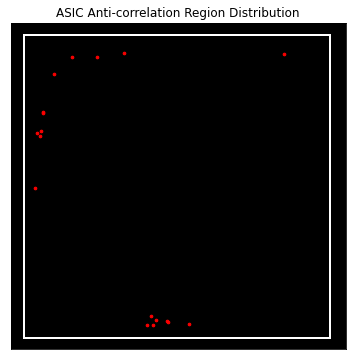

done


In [4]:
#%matplotlib

import matplotlib.pyplot as plt
import numpy as np

# Build data arrays

data_list_x = [x_position]
data_list_y = [y_position]

fig, ax = plt.subplots(figsize=(6,6))
plt.xlim([-50,1220]); plt.ylim([1320,-50])

import matplotlib.patches as mpatches
left, bottom, width, height = (0, 0, 1162, 1273)  # Accurate dimensions of ASIC
rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="white",
                       linewidth=2)
                       #facecolor="red")
plt.gca().add_patch(rect)
plt.scatter(data_list_x[0],data_list_y[0], s = 7, color = 'red')
plt.title('ASIC Anti-correlation Region Distribution')
plt.xticks([]); plt.yticks([])
ax.set_facecolor("black")
plt.savefig('ASIC ACR Distrbution.png',dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'white')

plt.show()

print('done')

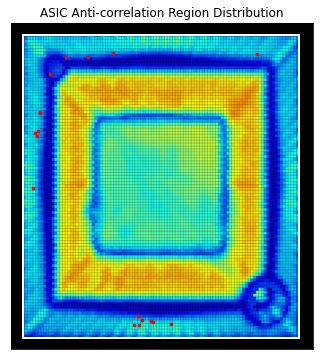

done


In [5]:
# Produce the same ACR plot, but you can overlay (in the background) an image of an amplitude plot

fig, ax = plt.subplots(figsize=(6,6))
plt.xlim([-50,1220]); plt.ylim([1320,-50])

import matplotlib.patches as mpatches
left, bottom, width, height = (0, 0, 1162, 1273)  # Accurate dimensions of ASIC
rect=mpatches.Rectangle((left,bottom),width,height, 
                        fill=False,
                        color="white",
                       linewidth=2)
                       #facecolor="red")

# Overlay image of SAM amplitude plot -- need to provide an amplitude plot, here
im0 = plt.imread('Example Amplitude Plot.png')
crop_img = im0[118:1391, 203:1365]
implot0 = plt.imshow(crop_img)
    
plt.gca().add_patch(rect)
plt.scatter(data_list_x[0],data_list_y[0], s = 7, color = 'red')
plt.title('ASIC Anti-correlation Region Distribution')
plt.xticks([]); plt.yticks([])
ax.set_facecolor("black")
plt.savefig('ASIC ACR Distrbution with Amp Plot.png',dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'white')

plt.show()

print('done')

In [9]:
# More work can be done from here. See the other scripts that were developed to investigate the
# ACRs based on failure mode, etc...

done
